In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 1. Importation of Processed Data

In [2]:
df = pd.read_excel('processed_midi_data.xlsx')

## 2. Outliers Detection Pipeline

In [3]:
class MusicOutlierDetector:
    def __init__(self, df):
        self.df = df.copy()
        self.outliers_summary = {}
        
    def detect_statistical_outliers(self, method='iqr', threshold=1.5):
        """Détection des outliers par méthodes statistiques"""
        print(f"🔍 Détection des outliers par méthode {method.upper()}")
        
        # Variables numériques à analyser (excluant les binaires)
        numeric_cols = [
            'onset', 'duration', 'polyphony', 'key', 'local_key', 'tempo',
            'measure', 'metric_weight', 'articulation_ratio', 'pitch',
            'pitch_octave', 'interval_to_prev', 'velocity', 'nb_beats',
            'beat_position_float', 'beat_fraction_float'
        ]
        
        outliers_dict = {}
        
        for col in numeric_cols:
            if col in self.df.columns:
                data = self.df[col]
                
                if method == 'iqr':
                    Q1 = data.quantile(0.25)
                    Q3 = data.quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - threshold * IQR
                    upper_bound = Q3 + threshold * IQR
                    
                    outliers = data[(data < lower_bound) | (data > upper_bound)]
                    
                elif method == 'zscore':
                    z_scores = np.abs(stats.zscore(data.dropna()))
                    outliers = data[z_scores > threshold]
                
                outliers_dict[col] = {
                    'count': len(outliers),
                    'percentage': (len(outliers) / len(data)) * 100,
                    'values': outliers.describe() if len(outliers) > 0 else None
                }
        
        self.outliers_summary[method] = outliers_dict
        return outliers_dict
    
    def analyze_suspicious_values(self):
        """Analyse des valeurs suspectes basée sur le domaine musical"""
        print("\n🎵 Analyse des valeurs suspectes dans le contexte musical")
        
        suspicious = {}
        
        # 1. Durées anormales
        long_notes = self.df[self.df['duration'] > 10]  # Notes > 10 secondes
        suspicious['durations_longues'] = {
            'count': len(long_notes),
            'max': self.df['duration'].max(),
            'description': 'Notes exceptionnellement longues (>10s)'
        }
        
        # 2. Articulation ratio extrêmes
        high_articulation = self.df[self.df['articulation_ratio'] > 2]
        suspicious['articulation_extreme'] = {
            'count': len(high_articulation),
            'max': self.df['articulation_ratio'].max(),
            'description': 'Ratios d\'articulation > 200%'
        }
        
        # 3. Intervalles mélodiques extrêmes
        large_intervals = self.df[self.df['interval_to_prev'] > 24]  # Plus de 2 octaves
        suspicious['intervalles_extremes'] = {
            'count': len(large_intervals),
            'max': self.df['interval_to_prev'].max(),
            'description': 'Intervalles > 2 octaves (24 demi-tons)'
        }
        
        # 4. Polyphonie excessive
        high_polyphony = self.df[self.df['polyphony'] > 15]
        suspicious['polyphonie_excessive'] = {
            'count': len(high_polyphony),
            'max': self.df['polyphony'].max(),
            'description': 'Polyphonie > 15 voix simultanées'
        }
        
        # 5. Tempos anormaux
        extreme_tempos = self.df[(self.df['tempo'] < 60) | (self.df['tempo'] > 180)]
        suspicious['tempos_extremes'] = {
            'count': len(extreme_tempos),
            'min': self.df['tempo'].min(),
            'max': self.df['tempo'].max(),
            'description': 'Tempos < 60 BPM ou > 180 BPM'
        }
        
        # 6. Beat fractions anormales
        high_beat_fraction = self.df[self.df['beat_fraction_float'] > 1.5]
        suspicious['beat_fractions_anormales'] = {
            'count': len(high_beat_fraction),
            'max': self.df['beat_fraction_float'].max(),
            'description': 'Fractions de temps > 1.5'
        }
        
        self.suspicious_values = suspicious
        return suspicious
    
    def visualize_outliers(self):
        """Visualisation des outliers"""
        print("\n📊 Visualisation des valeurs aberrantes")
        
        # Variables d'intérêt pour les boxplots
        key_vars = ['duration', 'articulation_ratio', 'interval_to_prev', 
                   'polyphony', 'tempo', 'velocity']
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('Distribution des variables avec outliers potentiels', fontsize=16)
        
        for i, var in enumerate(key_vars):
            row, col = i // 3, i % 3
            
            if var in self.df.columns:
                # Boxplot
                axes[row, col].boxplot(self.df[var].dropna())
                axes[row, col].set_title(f'{var}')
                axes[row, col].set_ylabel('Valeurs')
                
                # Ajout des statistiques
                stats_text = f"Max: {self.df[var].max():.2f}\nMin: {self.df[var].min():.2f}\nMéd: {self.df[var].median():.2f}"
                axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes, 
                                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        
        plt.tight_layout()
        plt.show()
        
        # Histogrammes pour les variables les plus problématiques
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Histogrammes des variables avec outliers significatifs', fontsize=16)
        
        problematic_vars = ['duration', 'articulation_ratio', 'interval_to_prev', 'polyphony']
        
        for i, var in enumerate(problematic_vars):
            row, col = i // 2, i % 2
            
            if var in self.df.columns:
                axes[row, col].hist(self.df[var].dropna(), bins=50, alpha=0.7, edgecolor='black')
                axes[row, col].set_title(f'Distribution de {var}')
                axes[row, col].set_xlabel(var)
                axes[row, col].set_ylabel('Fréquence')
                axes[row, col].axvline(self.df[var].median(), color='red', linestyle='--', label='Médiane')
                axes[row, col].legend()
        
        plt.tight_layout()
        plt.show()
    
    def analyze_special_values(self):
        """Analyse des valeurs spéciales (-1, 0, etc.)"""
        print("\n🔍 Analyse des valeurs spéciales")
        
        special_values = {}
        
        # Valeurs -1 (probablement des indicateurs de silence/manquant)
        cols_with_minus1 = ['pitch', 'pitch_octave', 'velocity']
        
        for col in cols_with_minus1:
            if col in self.df.columns:
                minus1_count = (self.df[col] == -1).sum()
                special_values[f'{col}_minus1'] = {
                    'count': minus1_count,
                    'percentage': (minus1_count / len(self.df)) * 100
                }
        
        # Valeurs 0 dans local_key (tonalité non définie ?)
        zero_local_key = (self.df['local_key'] == 0).sum()
        special_values['local_key_zero'] = {
            'count': zero_local_key,
            'percentage': (zero_local_key / len(self.df)) * 100
        }
        
        # Silences explicites
        explicit_rests = (self.df['is_rest'] == 1).sum()
        special_values['explicit_rests'] = {
            'count': explicit_rests,
            'percentage': (explicit_rests / len(self.df)) * 100
        }
        
        self.special_values = special_values
        return special_values
    
    def correlation_outlier_analysis(self):
        """Analyse des corrélations entre variables pour détecter des incohérences"""
        print("\n🔗 Analyse des corrélations et incohérences")
        
        # Matrice de corrélation
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        correlation_matrix = self.df[numeric_cols].corr()
        
        # Visualisation
        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='RdBu', center=0,
                   square=True, linewidths=0.5)
        plt.title('Matrice de corrélation des variables numériques')
        plt.tight_layout()
        plt.show()
        
        # Détection d'incohérences spécifiques
        inconsistencies = {}
        
        # 1. Notes avec pitch=-1 mais is_rest=0
        inconsistent_silence = self.df[(self.df['pitch'] == -1) & (self.df['is_rest'] == 0)]
        inconsistencies['pitch_rest_mismatch'] = len(inconsistent_silence)
        
        # 2. Velocity=-1 mais pitch!=-1 (note jouée sans vélocité)
        inconsistent_velocity = self.df[(self.df['velocity'] == -1) & (self.df['pitch'] != -1)]
        inconsistencies['velocity_pitch_mismatch'] = len(inconsistent_velocity)
        
        # 3. Durée très courte mais articulation_ratio élevé
        short_but_long_articulation = self.df[(self.df['duration'] < 0.1) & (self.df['articulation_ratio'] > 1)]
        inconsistencies['duration_articulation_conflict'] = len(short_but_long_articulation)
        
        self.inconsistencies = inconsistencies
        return inconsistencies
    
    def generate_report(self):
        """Génération d'un rapport complet sur les outliers"""
        print("\n" + "="*60)
        print("📊 RAPPORT COMPLET - VALEURS ABERRANTES")
        print("="*60)
        
        # Statistiques générales
        print(f"\n📈 STATISTIQUES GÉNÉRALES:")
        print(f"   Total d'observations: {len(self.df):,}")
        print(f"   Variables numériques: {len(self.df.select_dtypes(include=[np.number]).columns)}")
        
        # Valeurs spéciales
        if hasattr(self, 'special_values'):
            print(f"\n🔍 VALEURS SPÉCIALES:")
            for key, value in self.special_values.items():
                print(f"   {key}: {value['count']:,} ({value['percentage']:.1f}%)")
        
        # Valeurs suspectes
        if hasattr(self, 'suspicious_values'):
            print(f"\n⚠️  VALEURS SUSPECTES:")
            for key, value in self.suspicious_values.items():
                print(f"   {value['description']}: {value['count']:,} observations")
                if 'max' in value:
                    print(f"      Valeur max: {value['max']}")
                if 'min' in value:
                    print(f"      Valeur min: {value['min']}")
        
        # Incohérences
        if hasattr(self, 'inconsistencies'):
            print(f"\n❌ INCOHÉRENCES DÉTECTÉES:")
            for key, value in self.inconsistencies.items():
                print(f"   {key}: {value:,} observations")
        
        # Recommandations
        print(f"\n💡 RECOMMANDATIONS:")
        
        if hasattr(self, 'suspicious_values'):
            if self.suspicious_values['durations_longues']['count'] > 100:
                print("   ⚡ Examiner les durées > 10s (possibles erreurs d'encodage)")
            
            if self.suspicious_values['articulation_extreme']['count'] > 50:
                print("   ⚡ Vérifier les ratios d'articulation > 200% (probablement erronés)")
            
            if self.suspicious_values['polyphonie_excessive']['count'] > 10:
                print("   ⚡ Polyphonie > 15 voix suspecte (vérifier l'extraction)")
        
        if hasattr(self, 'special_values'):
            silence_rate = self.special_values.get('pitch_minus1', {}).get('percentage', 0)
            if silence_rate > 40:
                print(f"   ⚡ Taux de silence élevé ({silence_rate:.1f}%) - considérer le filtrage")
        
        print("\n" + "="*60)
    
    def run_complete_analysis(self):
        """Analyse complète des outliers"""
        print("🔍 === ANALYSE COMPLÈTE DES VALEURS ABERRANTES ===\n")
        
        # 1. Outliers statistiques
        self.detect_statistical_outliers(method='iqr', threshold=1.5)
        self.detect_statistical_outliers(method='zscore', threshold=3)
        
        # 2. Valeurs suspectes dans le contexte musical
        self.analyze_suspicious_values()
        
        # 3. Valeurs spéciales
        self.analyze_special_values()
        
        # 4. Visualisations
        self.visualize_outliers()
        
        # 5. Analyse des corrélations
        self.correlation_outlier_analysis()
        
        # 6. Rapport final
        self.generate_report()
        
        return {
            'outliers_summary': self.outliers_summary,
            'suspicious_values': self.suspicious_values,
            'special_values': self.special_values,
            'inconsistencies': self.inconsistencies
        }
    
def analyze_outliers(df):
    """Fonction principale pour analyser les outliers"""
    detector = MusicOutlierDetector(df)
    results = detector.run_complete_analysis()
    return detector, results

## 3. Results

🔍 === ANALYSE COMPLÈTE DES VALEURS ABERRANTES ===

🔍 Détection des outliers par méthode IQR
🔍 Détection des outliers par méthode ZSCORE

🎵 Analyse des valeurs suspectes dans le contexte musical

🔍 Analyse des valeurs spéciales

📊 Visualisation des valeurs aberrantes


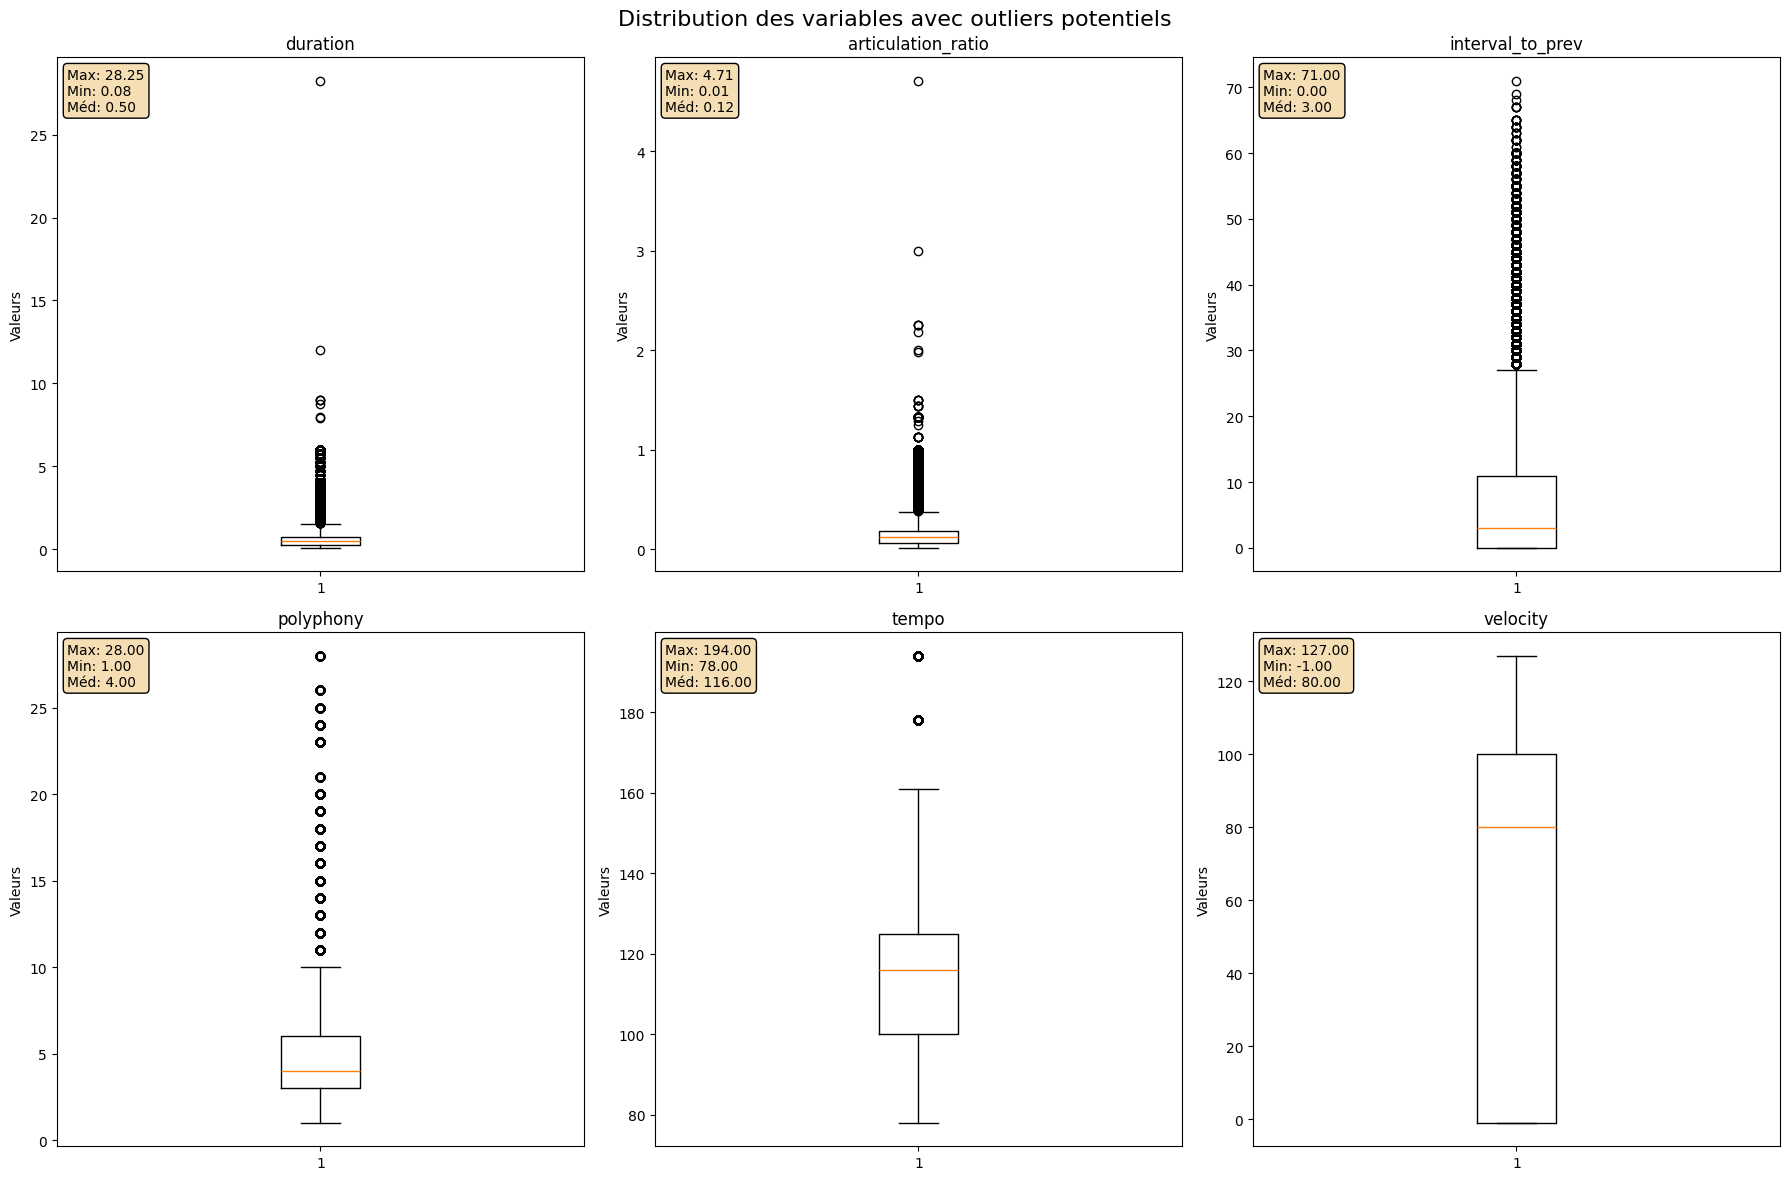

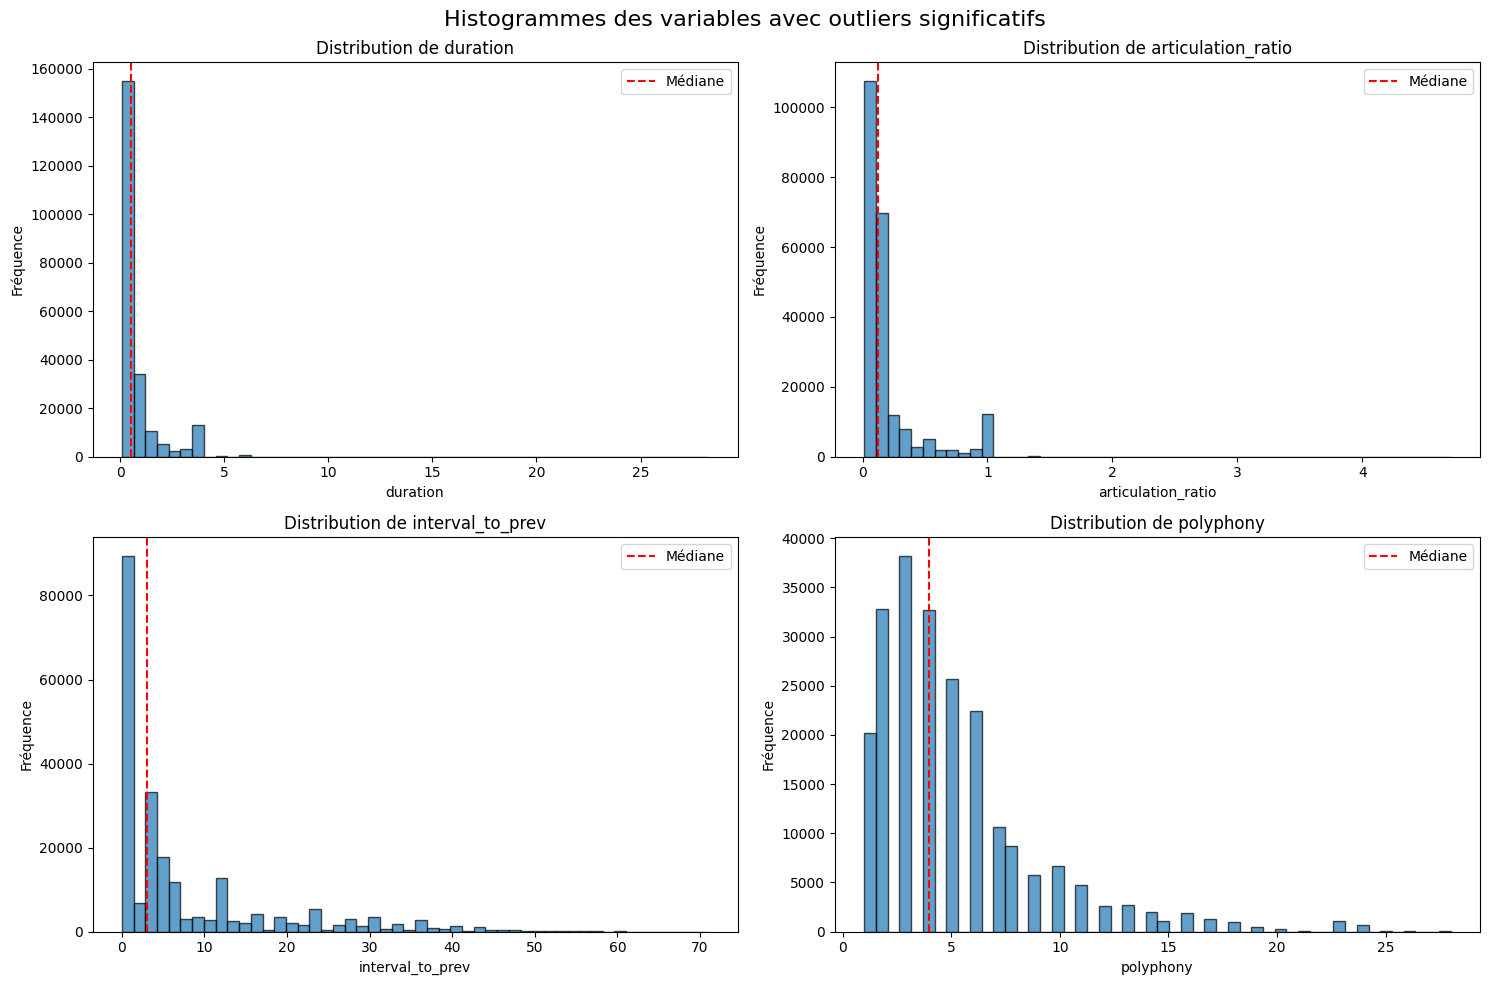


🔗 Analyse des corrélations et incohérences


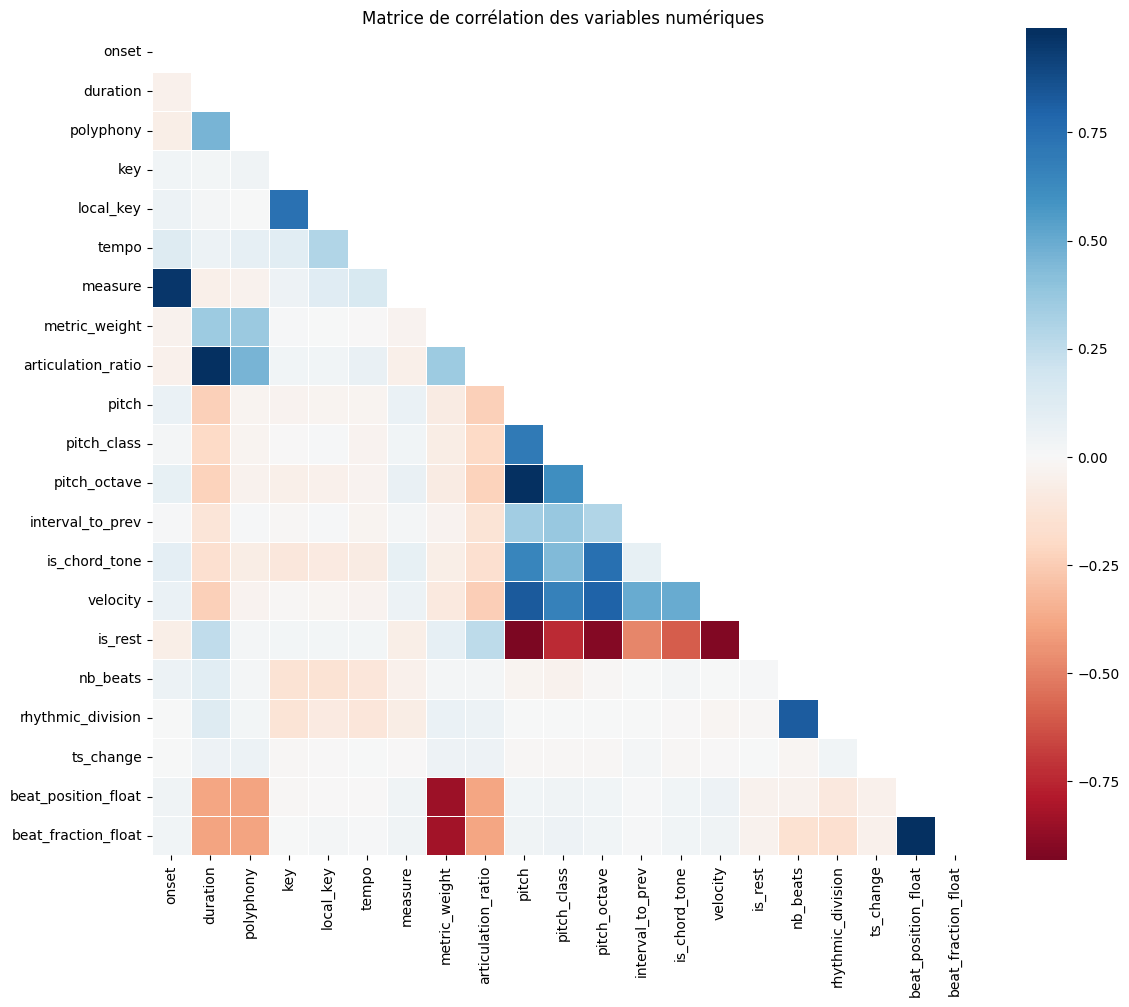


📊 RAPPORT COMPLET - VALEURS ABERRANTES

📈 STATISTIQUES GÉNÉRALES:
   Total d'observations: 223,830
   Variables numériques: 21

🔍 VALEURS SPÉCIALES:
   pitch_minus1: 73,016 (32.6%)
   pitch_octave_minus1: 73,016 (32.6%)
   velocity_minus1: 73,016 (32.6%)
   local_key_zero: 58,359 (26.1%)
   explicit_rests: 73,016 (32.6%)

⚠️  VALEURS SUSPECTES:
   Notes exceptionnellement longues (>10s): 2 observations
      Valeur max: 28.25
   Ratios d'articulation > 200%: 6 observations
      Valeur max: 4.708333333333333
   Intervalles > 2 octaves (24 demi-tons): 21,646 observations
      Valeur max: 71
   Polyphonie > 15 voix simultanées: 7,044 observations
      Valeur max: 28
   Tempos < 60 BPM ou > 180 BPM: 7,347 observations
      Valeur max: 194.0
      Valeur min: 78.0
   Fractions de temps > 1.5: 76 observations
      Valeur max: 1.75

❌ INCOHÉRENCES DÉTECTÉES:
   pitch_rest_mismatch: 0 observations
   velocity_pitch_mismatch: 0 observations
   duration_articulation_conflict: 0 observation

In [4]:
detector, outlier_results = analyze_outliers(df)

### Conclusions :

### Pas de retraitement nécessaire, mais filtrage recommandé
✅ Ce qui est NORMAL :
32.6% de silences : C'est cohérent pour de la musique ! Les silences sont une partie essentielle du rythme.
Intervalles > 2 octaves (21,646 obs) : Probablement normal selon vos genres :

Jazz : solos avec grands sauts
Classique : orchestration avec registres étendus
Électronique : effets et samples variés

Polyphonie élevée : Acceptable pour certains genres (orchestral, électronique avec layers)

# Filtrage ciblé, pas de ré-extraction
Votre extraction semble correcte ! Les "outliers" reflètent probablement la diversité naturelle de vos 15 genres musicaux. Voici ma stratégie :
✅ À GARDER (c'est normal) :

32.6% de silences → Les silences sont musicalement essentiels
Intervalles > 2 octaves → Normaux en jazz, classique, électronique
Polyphonie élevée → Attendue en orchestral/électronique

⚠️ À FILTRER pour la TDA :

2 durées > 10s → Probables erreurs d'encodage
6 articulations > 200% → Physiquement impossibles
Tempos extrêmes → Si hors contexte musical

In [5]:
def create_filtered_datasets(df):
    """Crée différentes versions filtrées du dataset pour l'analyse TDA"""
    
    print("🎵 === CRÉATION DES DATASETS FILTRÉS ===\n")
    
    datasets = {}
    
    # 1. Dataset original (référence)
    datasets['original'] = df.copy()
    
    # 2. Dataset filtré CONSERVATEUR (garde plus de données)
    print("📊 Dataset CONSERVATEUR (filtrage minimal)")
    df_conservative = df.copy()
    
    # Suppression des outliers extrêmes seulement
    df_conservative = df_conservative[
        (df_conservative['duration'] <= 10) &  # Notes < 10s
        (df_conservative['articulation_ratio'] <= 2) &  # Articulation < 200%
        (df_conservative['beat_fraction_float'] <= 1.5)  # Beat fraction normale
    ]
    
    datasets['conservative'] = df_conservative
    
    # 3. Dataset filtré MODÉRÉ (bon compromis)
    print("📊 Dataset MODÉRÉ (filtrage équilibré)")
    df_moderate = df.copy()
    
    # Filtres plus stricts mais raisonnables
    df_moderate = df_moderate[
        (df_moderate['duration'] <= 5) &  # Notes < 5s
        (df_moderate['articulation_ratio'] <= 1.5) &  # Articulation < 150%
        (df_moderate['interval_to_prev'] <= 36) &  # Intervalles < 3 octaves
        (df_moderate['polyphony'] <= 20) &  # Polyphonie raisonnable
        (df_moderate['tempo'] >= 60) & (df_moderate['tempo'] <= 180) &  # Tempos normaux
        (df_moderate['beat_fraction_float'] <= 1.5)
    ]
    
    datasets['moderate'] = df_moderate
    
    # 4. Dataset filtré STRICT (pour analyse fine)
    print("📊 Dataset STRICT (filtrage agressif)")
    df_strict = df.copy()
    
    # Filtres stricts pour l'analyse TDA propre
    df_strict = df_strict[
        (df_strict['duration'] <= 3) &  # Notes < 3s
        (df_strict['articulation_ratio'] <= 1.2) &  # Articulation normale
        (df_strict['interval_to_prev'] <= 24) &  # Max 2 octaves
        (df_strict['polyphony'] <= 15) &  # Polyphonie modérée
        (df_strict['tempo'] >= 80) & (df_strict['tempo'] <= 160) &  # Tempos standards
        (df_strict['beat_fraction_float'] <= 1.25)
    ]
    
    datasets['strict'] = df_strict
    
    # 5. Dataset NOTES SEULEMENT (sans silences)
    print("📊 Dataset NOTES SEULEMENT (pas de silences)")
    df_notes_only = df.copy()
    
    # Suppression des silences et valeurs -1
    df_notes_only = df_notes_only[
        (df_notes_only['pitch'] != -1) & 
        (df_notes_only['is_rest'] != 1) &
        (df_notes_only['velocity'] != -1)
    ].copy()
    
    # Application des filtres modérés
    df_notes_only = df_notes_only[
        (df_notes_only['duration'] <= 5) &
        (df_notes_only['articulation_ratio'] <= 1.5) &
        (df_notes_only['interval_to_prev'] <= 36) &
        (df_notes_only['polyphony'] <= 20) &
        (df_notes_only['tempo'] >= 60) & (df_notes_only['tempo'] <= 180)
    ]
    
    datasets['notes_only'] = df_notes_only
    
    return datasets

def compare_datasets(datasets):
    """Compare les différents datasets filtrés"""
    
    print("\n" + "="*80)
    print("📊 COMPARAISON DES DATASETS FILTRÉS")
    print("="*80)
    
    comparison = []
    
    for name, df in datasets.items():
        stats = {
            'Dataset': name,
            'Observations': len(df),
            'Pourcentage_gardé': f"{(len(df) / len(datasets['original'])) * 100:.1f}%",
            'Silences': f"{(df['is_rest'].sum() / len(df)) * 100:.1f}%" if 'is_rest' in df.columns else "N/A",
            'Durée_max': f"{df['duration'].max():.2f}s" if 'duration' in df.columns else "N/A",
            'Articulation_max': f"{df['articulation_ratio'].max():.2f}" if 'articulation_ratio' in df.columns else "N/A",
            'Intervalle_max': f"{df['interval_to_prev'].max():.0f}" if 'interval_to_prev' in df.columns else "N/A",
            'Polyphonie_max': f"{df['polyphony'].max():.0f}" if 'polyphony' in df.columns else "N/A"
        }
        comparison.append(stats)
    
    comparison_df = pd.DataFrame(comparison)
    print(comparison_df.to_string(index=False))
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Nombre d'observations
    names = list(datasets.keys())
    sizes = [len(df) for df in datasets.values()]
    
    axes[0,0].bar(names, sizes, color=['blue', 'green', 'orange', 'red', 'purple'])
    axes[0,0].set_title('Nombre d\'observations par dataset')
    axes[0,0].set_ylabel('Observations')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Distribution des durées
    for name, df in datasets.items():
        if name != 'original':  # Skip original pour la lisibilité
            axes[0,1].hist(df['duration'], bins=50, alpha=0.5, label=name, density=True)
    axes[0,1].set_title('Distribution des durées (datasets filtrés)')
    axes[0,1].set_xlabel('Durée (s)')
    axes[0,1].legend()
    
    # Distribution des intervalles
    for name, df in datasets.items():
        if name != 'original':
            axes[1,0].hist(df['interval_to_prev'], bins=50, alpha=0.5, label=name, density=True)
    axes[1,0].set_title('Distribution des intervalles (datasets filtrés)')
    axes[1,0].set_xlabel('Intervalle (demi-tons)')
    axes[1,0].legend()
    
    # Distribution de la polyphonie
    for name, df in datasets.items():
        if name != 'original':
            axes[1,1].hist(df['polyphony'], bins=30, alpha=0.5, label=name, density=True)
    axes[1,1].set_title('Distribution de la polyphonie (datasets filtrés)')
    axes[1,1].set_xlabel('Nombre de voix')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

def recommend_dataset_for_tda(datasets):
    """Recommande le meilleur dataset pour l'analyse TDA"""
    
    print("\n" + "="*80)
    print("🎯 RECOMMANDATIONS POUR L'ANALYSE TDA")
    print("="*80)
    
    print("\n📊 POUR DIFFÉRENTS OBJECTIFS :")
    
    print("\n🔍 ANALYSE EXPLORATOIRE INITIALE :")
    print("   → Dataset CONSERVATEUR")
    print(f"   → {len(datasets['conservative']):,} observations ({(len(datasets['conservative']) / len(datasets['original'])) * 100:.1f}% des données)")
    print("   → Garde la diversité, supprime juste les erreurs évidentes")
    
    print("\n🎵 ANALYSE TDA HARMONIQUE :")
    print("   → Dataset NOTES SEULEMENT")
    print(f"   → {len(datasets['notes_only']):,} observations ({(len(datasets['notes_only']) / len(datasets['original'])) * 100:.1f}% des données)")
    print("   → Focus sur les vraies notes, sans silences")
    
    print("\n🔬 ANALYSE TDA DÉTAILLÉE :")
    print("   → Dataset MODÉRÉ")
    print(f"   → {len(datasets['moderate']):,} observations ({(len(datasets['moderate']) / len(datasets['original'])) * 100:.1f}% des données)")
    print("   → Bon compromis entre qualité et quantité")
    
    print("\n⚡ ANALYSE TDA RAPIDE/PROTOTYPE :")
    print("   → Dataset STRICT")
    print(f"   → {len(datasets['strict']):,} observations ({(len(datasets['strict']) / len(datasets['original'])) * 100:.1f}% des données)")
    print("   → Données très propres, calculs plus rapides")
    
    print("\n💡 STRATÉGIE RECOMMANDÉE :")
    print("   1. Commencez avec le dataset MODÉRÉ pour l'analyse principale")
    print("   2. Utilisez NOTES SEULEMENT pour l'analyse harmonique pure")
    print("   3. Validez avec CONSERVATEUR pour vérifier la robustesse")
    print("   4. Utilisez STRICT pour les tests rapides et prototypes")

def create_genre_aware_filters(df, genre_column=None):
    """Filtres spécifiques par genre (si disponible)"""
    
    if genre_column is None or genre_column not in df.columns:
        print("ℹ️  Pas de colonne genre disponible - filtres génériques appliqués")
        return None
    
    print(f"\n🎸 FILTRES SPÉCIFIQUES PAR GENRE (colonne: {genre_column})")
    
    genre_filters = {
        'classical': {
            'polyphony_max': 25,  # Orchestral peut être complexe
            'interval_max': 48,   # Plus de liberté mélodique
            'tempo_range': (40, 180)
        },
        'jazz': {
            'polyphony_max': 15,
            'interval_max': 36,   # Solos avec grands sauts
            'tempo_range': (60, 200)
        },
        'electronic': {
            'polyphony_max': 30,  # Layers multiples
            'interval_max': 60,   # Samples variés
            'tempo_range': (80, 200)
        },
        'pop': {
            'polyphony_max': 12,
            'interval_max': 24,   # Mélodies plus simples
            'tempo_range': (70, 160)
        },
        'default': {
            'polyphony_max': 20,
            'interval_max': 36,
            'tempo_range': (60, 180)
        }
    }
    
    return genre_filters

# ========================
# FONCTION PRINCIPALE
# ========================

def filter_data_for_tda(df, genre_column=None):
    """Fonction principale pour filtrer les données pour l'analyse TDA"""
    
    print("🎵 === PRÉPARATION DES DONNÉES POUR L'ANALYSE TDA ===\n")
    
    # Création des datasets filtrés
    datasets = create_filtered_datasets(df)
    
    # Comparaison
    comparison = compare_datasets(datasets)
    
    # Recommandations
    recommend_dataset_for_tda(datasets)
    
    # Filtres par genre si disponible
    genre_filters = create_genre_aware_filters(df, genre_column)
    
    return datasets, comparison, genre_filters

# Exemple d'utilisation:
# datasets, comparison, genre_filters = filter_data_for_tda(df)
# 
# # Pour utiliser un dataset spécifique:
# df_clean = datasets['moderate']  # ou 'notes_only', 'conservative', etc.

print("Code prêt ! Utilisez: datasets, comparison, genre_filters = filter_data_for_tda(df)")

Code prêt ! Utilisez: datasets, comparison, genre_filters = filter_data_for_tda(df)


🎵 === PRÉPARATION DES DONNÉES POUR L'ANALYSE TDA ===

🎵 === CRÉATION DES DATASETS FILTRÉS ===

📊 Dataset CONSERVATEUR (filtrage minimal)
📊 Dataset MODÉRÉ (filtrage équilibré)
📊 Dataset STRICT (filtrage agressif)
📊 Dataset NOTES SEULEMENT (pas de silences)

📊 COMPARAISON DES DATASETS FILTRÉS
     Dataset  Observations Pourcentage_gardé Silences Durée_max Articulation_max Intervalle_max Polyphonie_max
    original        223830            100.0%    32.6%    28.25s             4.71             71             28
conservative        223748            100.0%    32.6%     8.00s             2.00             71             28
    moderate        207598             92.7%    32.9%     5.00s             1.33             36             20
      strict        166265             74.3%    32.5%     3.00s             1.00             24             15
  notes_only        139306             62.2%     0.0%     5.00s             1.25             36             20


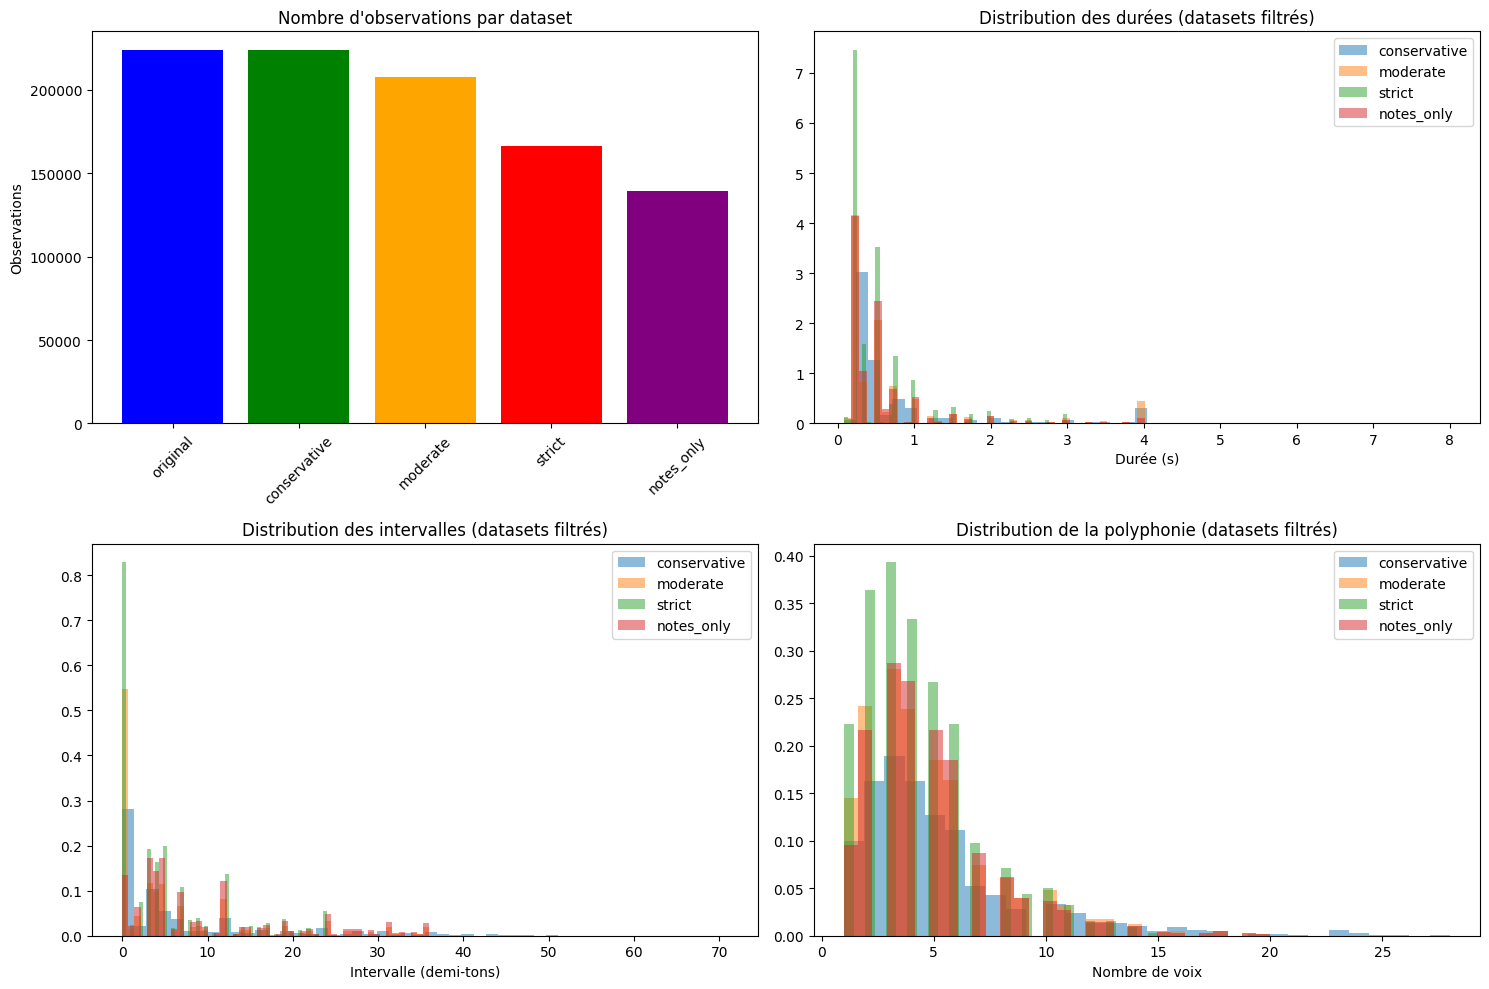


🎯 RECOMMANDATIONS POUR L'ANALYSE TDA

📊 POUR DIFFÉRENTS OBJECTIFS :

🔍 ANALYSE EXPLORATOIRE INITIALE :
   → Dataset CONSERVATEUR
   → 223,748 observations (100.0% des données)
   → Garde la diversité, supprime juste les erreurs évidentes

🎵 ANALYSE TDA HARMONIQUE :
   → Dataset NOTES SEULEMENT
   → 139,306 observations (62.2% des données)
   → Focus sur les vraies notes, sans silences

🔬 ANALYSE TDA DÉTAILLÉE :
   → Dataset MODÉRÉ
   → 207,598 observations (92.7% des données)
   → Bon compromis entre qualité et quantité

⚡ ANALYSE TDA RAPIDE/PROTOTYPE :
   → Dataset STRICT
   → 166,265 observations (74.3% des données)
   → Données très propres, calculs plus rapides

💡 STRATÉGIE RECOMMANDÉE :
   1. Commencez avec le dataset MODÉRÉ pour l'analyse principale
   2. Utilisez NOTES SEULEMENT pour l'analyse harmonique pure
   3. Validez avec CONSERVATEUR pour vérifier la robustesse
   4. Utilisez STRICT pour les tests rapides et prototypes
ℹ️  Pas de colonne genre disponible - filtres généri

In [6]:
datasets, comparison, genre_filters = filter_data_for_tda(df)

## Création des datasets

In [10]:
# Pour l'analyse TDA principale
df_clean = datasets['moderate']
df_clean.to_excel('/datasets/df_clean.xlsx', index=False)

# Pour l'analyse harmonique
df_harmonic = datasets['notes_only']
df_harmonic.to_excel('/datasets/df_harmonic.xlsx', index=False)

In [8]:
df_clean.describe()

,onset,duration,polyphony,key,local_key,tempo,measure,metric_weight,articulation_ratio,pitch,...,pitch_octave,interval_to_prev,is_chord_tone,velocity,is_rest,nb_beats,rhythmic_division,ts_change,beat_position_float,beat_fraction_float
count,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,...,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000,207598.000000
mean,225.531016,0.747221,4.765889,10.562510,7.617511,113.918808,55.463150,0.599657,0.187767,39.600136,...,2.455390,6.626706,0.441425,61.754309,0.329252,3.994740,0.016402,0.002500,2.631489,0.662073
std,144.494823,0.923872,3.194217,7.803241,7.673647,20.025165,34.125588,0.311026,0.232468,30.274093,...,2.647735,9.084716,0.496558,48.106754,0.469943,0.321938,0.127016,0.049938,1.220544,0.308738
min,0.000000,0.083333,1.000000,0.000000,0.000000,78.000000,0.000000,0.200000,0.013889,-1.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.166667
25%,112.000000,0.250000,3.000000,3.000000,0.000000,100.000000,28.000000,0.400000,0.062500,-1.000000,...,-1.000000,0.000000,0.000000,-1.000000,0.000000,4.000000,0.000000,0.000000,1.500000,0.375000
50%,209.000000,0.333333,4.000000,10.000000,5.000000,116.000000,52.000000,0.600000,0.111111,53.000000,...,3.000000,3.000000,0.000000,80.000000,0.000000,4.000000,0.000000,0.000000,2.500000,0.625000
75%,314.000000,0.750000,6.000000,17.000000,13.000000,125.000000,78.000000,1.000000,0.187500,65.000000,...,5.000000,9.000000,1.000000,100.000000,1.000000,4.000000,0.000000,0.000000,3.750000,0.937500
max,755.833333,5.000000,20.000000,23.000000,23.000000,178.000000,176.000000,1.000000,1.333333,108.000000,...,9.000000,36.000000,1.000000,127.000000,1.000000,6.000000,1.000000,1.000000,6.000000,1.500000


In [9]:
df_harmonic.describe()

,onset,duration,polyphony,key,local_key,tempo,measure,metric_weight,articulation_ratio,pitch,...,pitch_octave,interval_to_prev,is_chord_tone,velocity,is_rest,nb_beats,rhythmic_division,ts_change,beat_position_float,beat_fraction_float
count,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000,...,139306.000000,139306.000000,139306.000000,139306.000000,139306.0,139306.000000,139306.000000,139306.000000,139306.000000,139306.000000
mean,231.500288,0.599301,4.818500,10.382417,7.459492,113.626340,56.856187,0.583617,0.150128,59.531908,...,4.151537,9.880386,0.657983,92.547808,0.0,3.994882,0.019238,0.002412,2.654013,0.668424
std,148.065294,0.650347,2.957198,7.664036,7.484788,19.933528,34.965324,0.304747,0.161205,12.651539,...,1.308952,9.533802,0.474387,23.846141,0.0,0.347163,0.137362,0.049053,1.184871,0.300493
min,0.000000,0.083333,1.000000,0.000000,0.000000,78.000000,1.000000,0.200000,0.020833,22.000000,...,0.000000,0.000000,0.000000,1.000000,0.0,3.000000,0.000000,0.000000,1.000000,0.166667
25%,116.000000,0.250000,3.000000,3.000000,0.000000,100.000000,29.000000,0.400000,0.062500,52.000000,...,3.000000,3.000000,0.000000,80.000000,0.0,4.000000,0.000000,0.000000,1.500000,0.375000
50%,213.500000,0.333333,4.000000,10.000000,5.000000,116.000000,53.000000,0.600000,0.111111,61.000000,...,4.000000,5.000000,1.000000,96.000000,0.0,4.000000,0.000000,0.000000,2.500000,0.666667
75%,319.333333,0.500000,6.000000,17.000000,13.000000,125.000000,79.000000,1.000000,0.166667,68.000000,...,5.000000,14.000000,1.000000,110.000000,0.0,4.000000,0.000000,0.000000,3.666667,0.937500
max,755.500000,5.000000,20.000000,23.000000,23.000000,178.000000,176.000000,1.000000,1.250000,108.000000,...,9.000000,36.000000,1.000000,127.000000,0.0,6.000000,1.000000,1.000000,5.000000,1.583333
